**Description:** Demonstrate how to make a new analysis tool, a plot/metric

**Contact authors:** Sophie Reed

**Last verified to run:** 2023-05-23

**LSST Science Piplines version:** w_2023_20

**Container Size:** Medium (or larger)

**Location:** This notebook points to files on the S3DF cluster at the USDF. Update paths accordingly if you are running elsewhere.

**Skills:** Make a new analysis tool and have a play with some data

Import statements that we will need later

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lsst.analysis.tools
from lsst.analysis.tools.interfaces import AnalysisTool
from lsst.analysis.tools.actions.vector import CoaddPlotFlagSelector, SnSelector, StarSelector, LoadVector, ExtinctionCorrectedMagDiff
from lsst.analysis.tools.actions.scalar import MedianAction, MeanAction, SigmaMadAction
from lsst.analysis.tools.actions.plot import SkyPlot
from lsst.analysis.tools.atools import ShapeSizeFractionalDiff

import lsst.daf.butler as dafButler
from lsst.analysis.tools.interfaces._task import _StandinPlotInfo

Let's make a new plot and metric tool, we'll base it on the example in the getting started guide.

In [2]:
class newPlotMetric(AnalysisTool):
    def setDefaults(self):
        super().setDefaults()
        self.prep.selectors.flagSelector = CoaddPlotFlagSelector()
        self.prep.selectors.flagSelector.bands = []

        self.prep.selectors.snSelector = SnSelector()
        self.prep.selectors.snSelector.fluxType = "{band}_psfFlux"
        self.prep.selectors.snSelector.threshold = 300

        self.prep.selectors.starSelector = StarSelector()
        self.prep.selectors.starSelector.vectorKey = "{band}_extendedness"

        self.process.buildActions.xStars = LoadVector()
        self.process.buildActions.xStars.vectorKey = "coord_ra"
        self.process.buildActions.yStars = LoadVector()
        self.process.buildActions.yStars.vectorKey = "coord_dec"

        self.process.buildActions.starStatMask = SnSelector()
        self.process.buildActions.starStatMask.fluxType = "{band}_psfFlux"

        self.process.buildActions.zStars = ExtinctionCorrectedMagDiff()
        self.process.buildActions.zStars.magDiff.col1 = "{band}_ap12Flux"
        self.process.buildActions.zStars.magDiff.col2 = "{band}_psfFlux"

        self.process.calculateActions.median = MedianAction()
        self.process.calculateActions.median.vectorKey = "zStars"

        self.process.calculateActions.mean = MeanAction()
        self.process.calculateActions.mean.vectorKey = "zStars"

        self.process.calculateActions.sigmaMad = SigmaMadAction()
        self.process.calculateActions.sigmaMad.vectorKey = "xStars"

        self.produce.plot = SkyPlot()
        self.produce.plot.plotTypes = ["stars"]
        self.produce.plot.plotName = "ap12-psf_{band}"
        self.produce.plot.xAxisLabel = "R.A. (degrees)"
        self.produce.plot.yAxisLabel = "Dec. (degrees)"
        self.produce.plot.zAxisLabel = "Ap 12 - PSF [mag]"
        self.produce.plot.plotOutlines = False

        self.produce.metric.units = {
            "median": "mmag",
            "sigmaMad": "mmag",
            "mean": "mmag"
        }

        self.produce.metric.newNames = {
            "median": "{band}_ap12-psf_median",
            "mean": "{band}_ap12-psf_mean",
            "sigmaMad": "{band}_ap12-psf_sigmaMad",
        }

Now we have a tool we need some data to run it on. We're going to run it on the object table tract.

In [3]:
dataId = {"skymap": "hsc_rings_v1", "tract": 9813, "instrument": "HSC"}
collections = ['u/bechtol']
repo = '/sdf/group/rubin/user/bechtol/bootcamp_2023_backup/rc2_subset/SMALL_HSC/'
Butler = dafButler.Butler(repo)
t = Butler.get("objectTable_tract", dataId=dataId, collections=collections)

We want to include some information on the plot for future reference, as much information as possible should be included here so that future you is less annoyed with past you when they can't recreate the plot.

If you can't be bothered to make a dict of the information to include then you can use ```_StandInPlotInfo``` from ```lsst.analysis.tools.interfaces._task```.

In [4]:
plotInfoDict = {"bands": "i", "tract": 9813, "tableName": "objectTable_tract", "run": collections[0]}

Now we have all of the pieces let's run the tool! You need to remember to call finalize before trying to get results back.

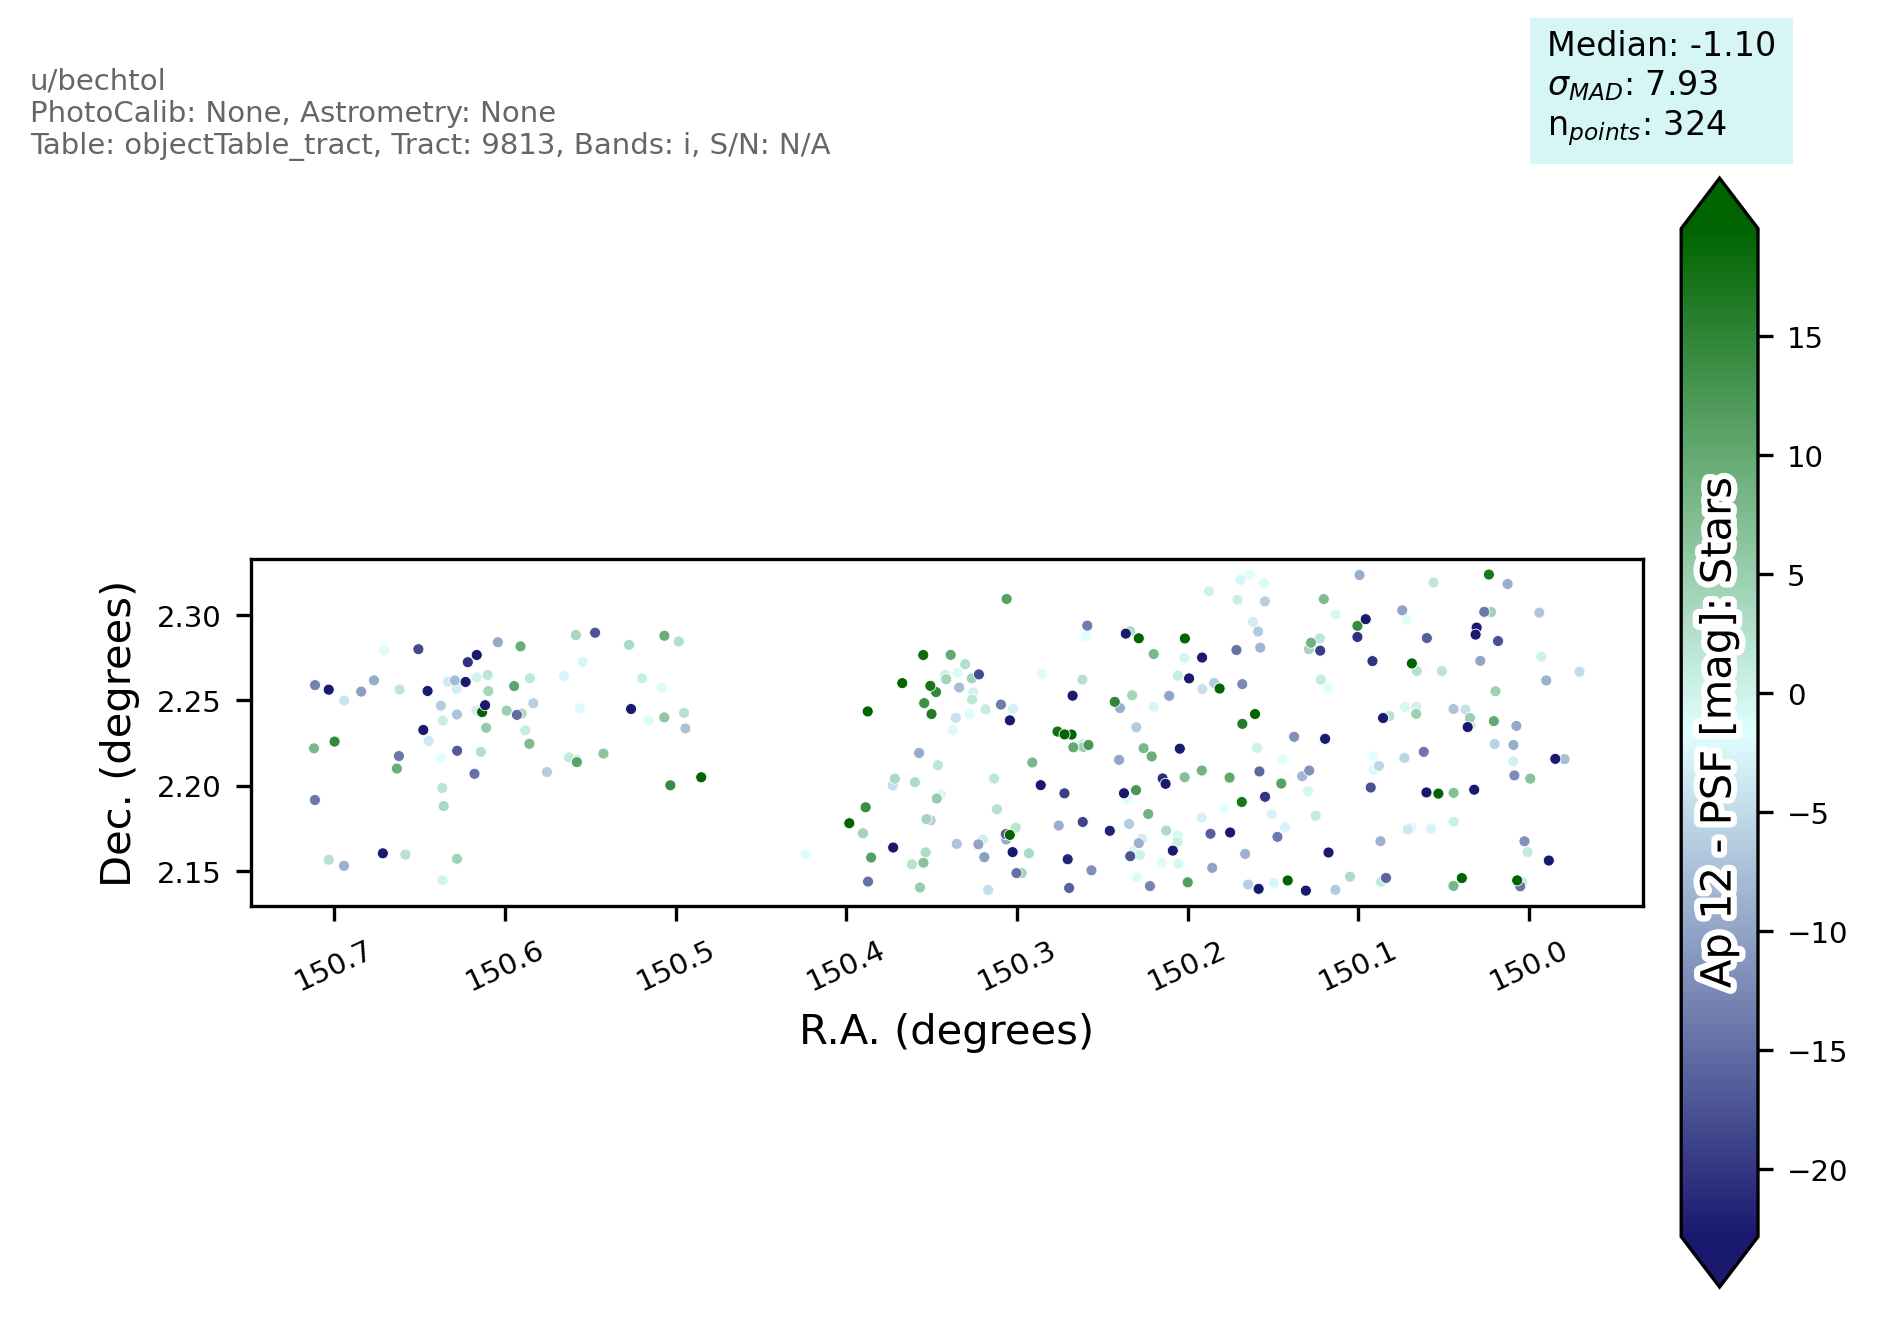

In [5]:
atool = newPlotMetric()
atool.finalize()
results = atool(t, band="i", plotInfo=plotInfoDict)

A plot has been made, but it looks a bit sparse, only 333 objects that made it to the plot. Let's look into why, first step, let us look at each selector individually and see what they are doing to the input data.

In [6]:
print("The number of sources in the object table:", len(t))
print("The results of the tool:", results)

# Find out how many things are removed by each selector
# The star selector:
starSelector = StarSelector()
starMask = starSelector(t, band="i")
print("Number of stars:", np.sum(starMask))

# The flag selector
flagSelector = CoaddPlotFlagSelector()
flagMask = flagSelector(t, band="i")
print("Number of unflagged objects:", np.sum(flagMask))

# The S/N selector
snSelector = SnSelector()
snSelector.fluxType = "i_psfFlux"
snSelector.threshold = 300
snMask = snSelector(t)
print("Number of objects that satisfy the S/N cut:", np.sum(snMask))

# See how many make it through everything
totMask = starMask & snMask & flagMask
print("Total number of selected objects:", np.sum(totMask))

The number of sources in the object table: 108382
The results of the tool: {'SkyPlot': <Figure size 1920x1440 with 2 Axes>, 'i_ap12-psf_median': Measurement('i_ap12-psf_median', <Quantity -1.66305519 mmag>, notes={'i_ap12-psf_median.metric_tags': []}), 'i_ap12-psf_sigmaMad': Measurement('i_ap12-psf_sigmaMad', <Quantity 0.17841919 mmag>, notes={'i_ap12-psf_sigmaMad.metric_tags': []}), 'i_ap12-psf_mean': Measurement('i_ap12-psf_mean', <Quantity -4.89691544 mmag>, notes={'i_ap12-psf_mean.metric_tags': []})}
Number of stars: 13190
Number of unflagged objects: 50314
Number of objects that satisfy the S/N cut: 2081
Total number of selected objects: 324


It seems that the S/N selector is removing a lot of objects, typically we expect a threshold of 300 to be appropriate for HSC data. Let's investigate the S/N across the whole catalogue.

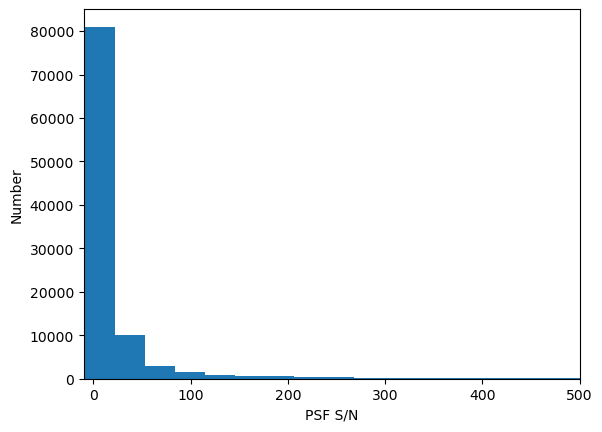

In [7]:
plt.hist(t["i_psfFlux"]/t["i_psfFluxErr"], bins=100)
plt.xlim(-10, 500)
plt.xlabel("PSF S/N")
plt.ylabel("Number")
plt.show()

Let's check that the S/N issues aren't limited to just a couple of patches

In [8]:
print("Patches that have sources that pass the S/N cut:", set(list((t["patch"][snMask]))))
print("Patches in the data:", set(list((t["patch"]))))
patches = list(set(list(t["patch"])))

Patches that have sources that pass the S/N cut: {40, 41, 38, 39}
Patches in the data: {40, 41, 38, 39}


So all the patches have some high S/N points on them let's look at an image and see if it looks like junk.

In [9]:
# Add the patch and band to the dataId, we didn't need them for the objectTable_tract because it covers all patches and bands
# However the coadds are stored by patch and band dimensions so we have to add them to the dataId
dataId["band"] = "i"
dataId["patch"] = 41

im = Butler.get("deepCoadd_calexp", dataId=dataId, collections=collections)

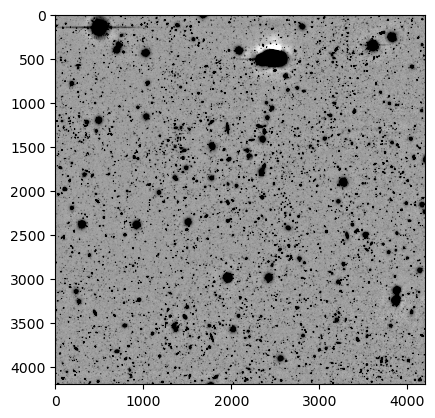

In [10]:
# Display the image with a suitable scaling
med = np.median(im.image.array.flatten())
sigMad = 1.4826 * np.median(np.fabs(im.image.array.flatten() - med))
vmin = med - 3 * sigMad
vmax = med + 3 * sigMad
plt.imshow(im.image.array, vmin=vmin, vmax=vmax, cmap="Greys")
plt.show()

The image looks fine, next lets look at how many visits went into each point. ```i_inputCount``` tells you how many visits covered the object.

In [11]:
def catOutline(ras, decs):
    """A utility function to help draw outlines of points of ra and dec
    
    Parameters
    ----------
    ras : iterable
        The R.A. of the points
    decs : iterable
        The declination of the points
        
    Returns
    -------
    xMids : np.array
        The midpoints of the bins on the x axis
    yMids : np.array
        The midpoints of the bins on the y axis
    im : np.array
        A 2D array of the number of points in each bin
    """
    
    xWalls = np.linspace(np.min(ras) - 0.1, np.max(ras) + 0.1, 101)
    yWalls = np.linspace(np.min(decs) - 0.1, np.max(decs) + 0.1, 101)
    
    im, xBins, yBins = np.histogram2d(ras, decs, bins=(xWalls, yWalls))
    xMids = 0.5*(xBins[:-1] + xBins[1:])
    yMids = 0.5*(yBins[:-1] + yBins[1:])
    im[im > 0] = 1
    
    return xMids, yMids, im
    

To look at the visits that went into our object table we need to first find the data that went into it. The coadds are made from the visit level calexps so we will have a look at the calexps that are available in the butler. This gives us a list of visits. Once we have the visits we can read in the tables for each visit and then use those to plot the overlaps.


Numbers of input visits: {0, 1, 2, 3, 4, 5, 6, 7}
Total number of visits: 8


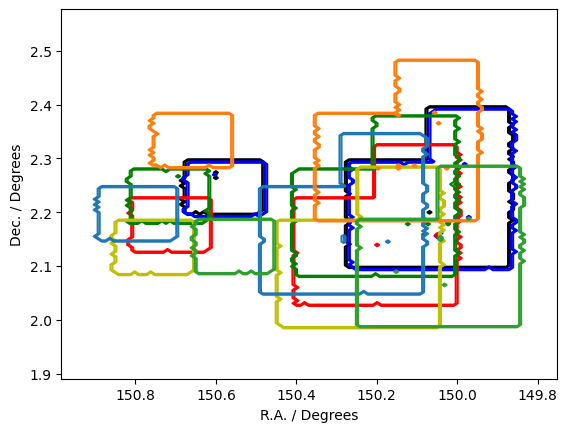

In [12]:
print("Numbers of input visits:", set(list(t["i_inputCount"])))

# Get the visit numbers that went into the coadds, we don't actually need to read in the calexps but we want to
# get the visit numbers from their dataIds

registry = Butler.registry
refs = registry.queryDatasets("calexp", collections=collections)
visits = []
for ref in refs:
    if ref.dataId["band"] == "i":
        visits.append(ref.dataId["visit"])

visits = list(set(visits))
print("Total number of visits:", len(visits))

# Plot the visit outlines so we can look at the overlaps 
colours = ["k", "b", "r", "g", "y", "C0", "C1", "C2"]
for (i, visit) in enumerate(visits):
    dataId["visit"] = visit
    visitTable = Butler.get("sourceTable_visit", dataId=dataId, collections=collections)
    xMids, yMids, im = catOutline(visitTable["coord_ra"], visitTable["coord_dec"])
    plt.contour(xMids, yMids, im.T, 1, colors=[colours[i]])

plt.gca().invert_xaxis()
plt.xlabel("R.A. / Degrees")
plt.ylabel("Dec. / Degrees")
plt.show()



There are only 8 visits and they don't all overlap everywhere, the data isn't going to have very high S/N.

Now we know that the data isn't very deep we can adjust the signal to noise threshold so that we have more points on the plot

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:65: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


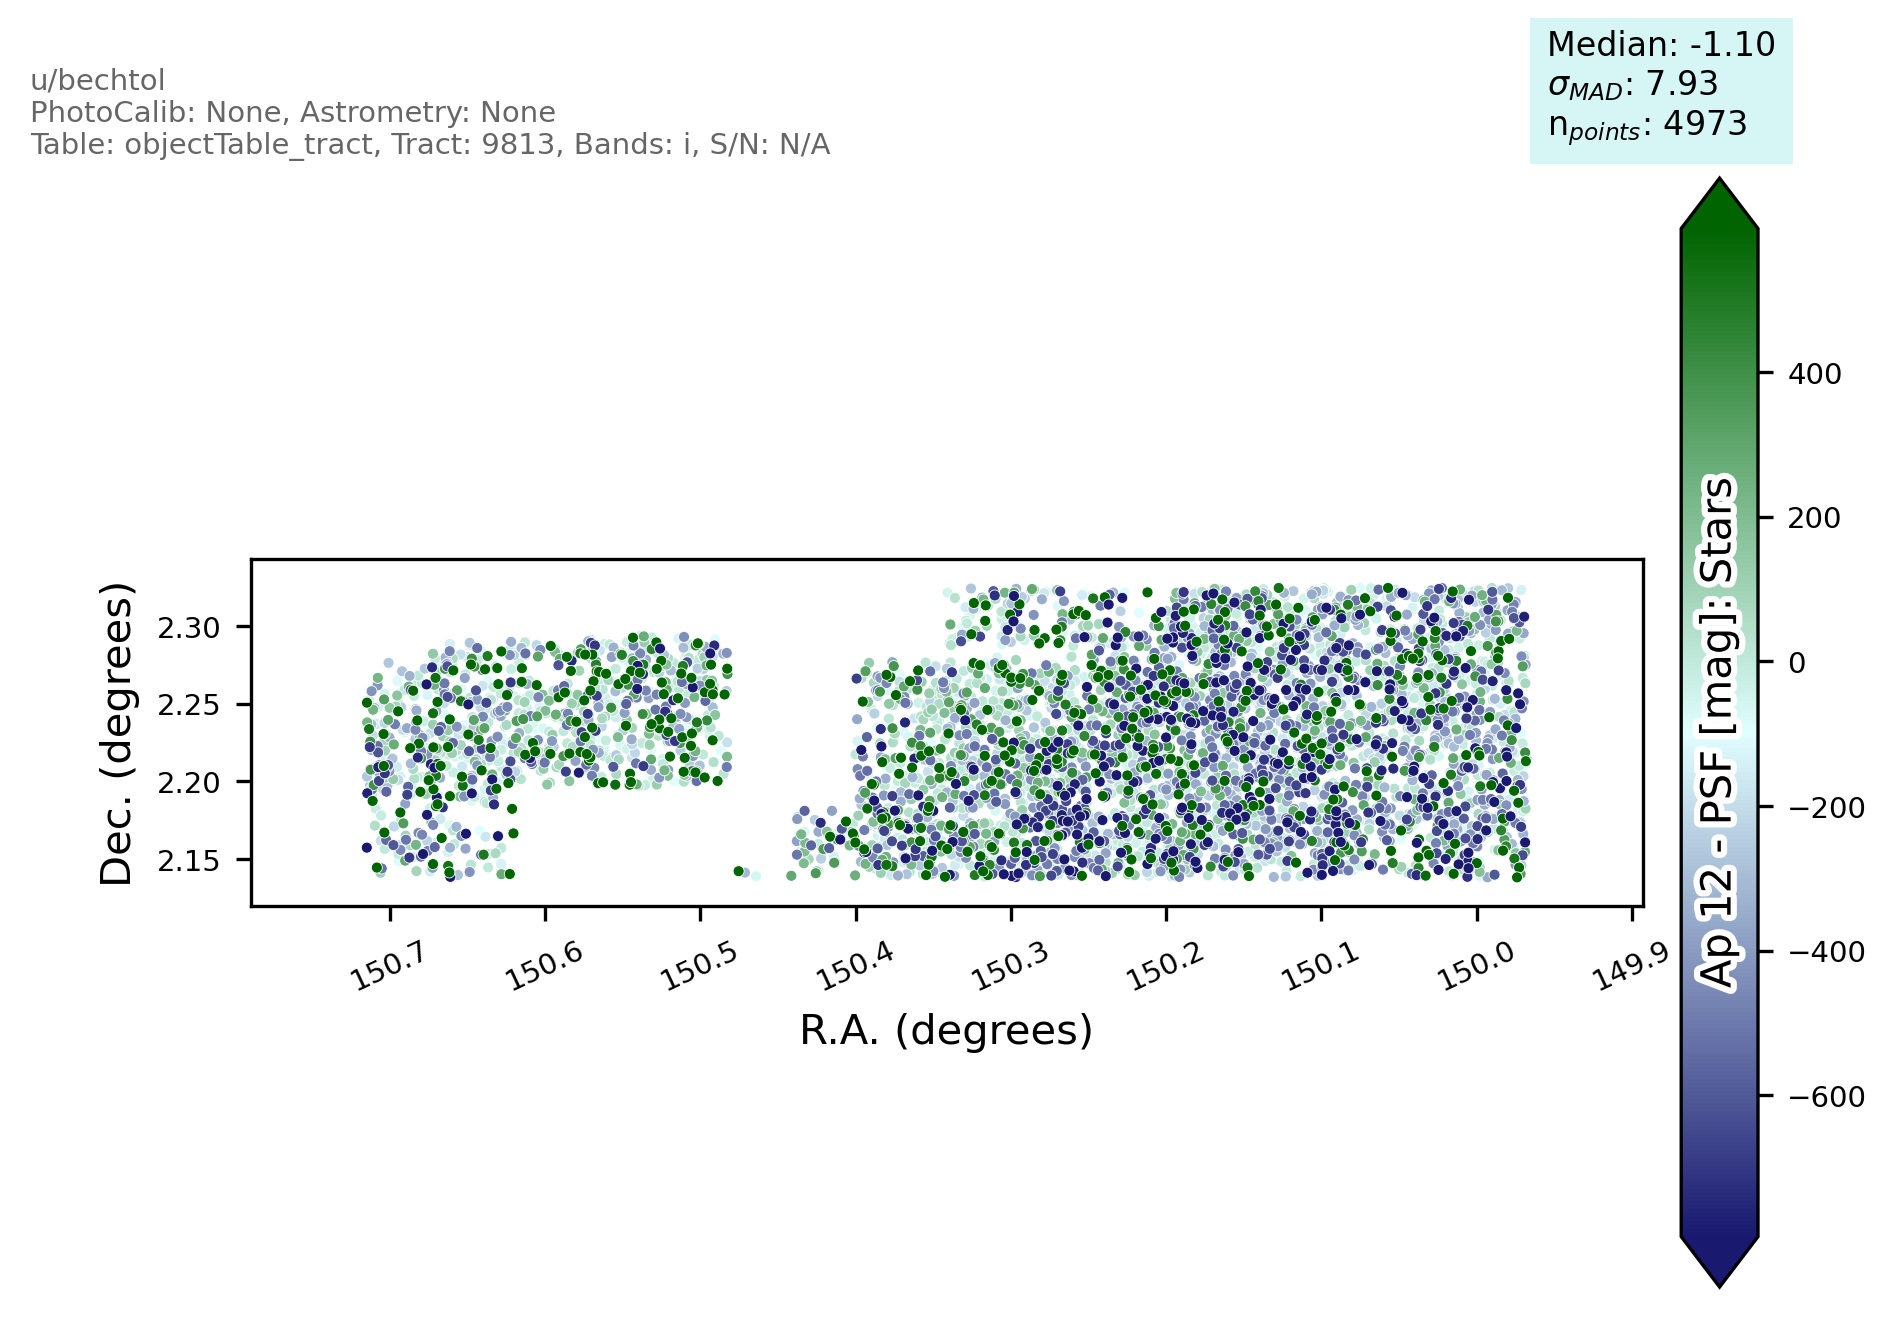

In [13]:
atool = newPlotMetric()
# Adjust the threshold
atool.prep.selectors.snSelector.threshold = 5
atool.finalize()
results = atool(t, band="i", plotInfo=plotInfoDict)

The data still doesn't cover all the area that the visits covered, let's look at why.
We'll plot the patch outlines over the input visits, we know that only four patches are in the final catalogue.

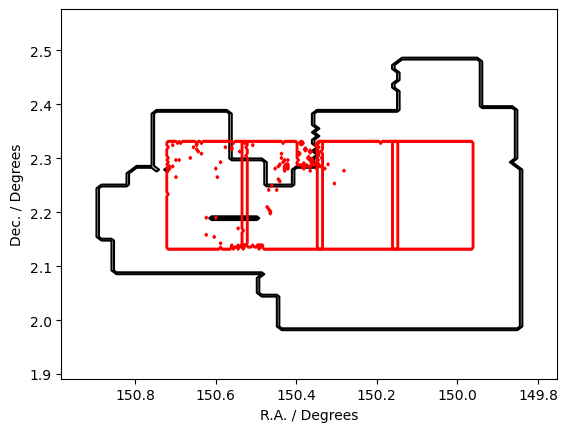

In [14]:
# Take all the ras and decs from the visit catalogues
# Is this the most efficent way to do this, probably not

rasAll = []
decsAll = []

for visit in visits:
    dataId["visit"] = visit
    visitTable = Butler.get("sourceTable_visit", dataId=dataId, collections=collections)
    rasAll += list(visitTable["coord_ra"])
    decsAll += list(visitTable["coord_dec"])
    
xMids, yMids, im = catOutline(rasAll, decsAll)
plt.contour(xMids, yMids, im.T, 1, colors=["k"])
    
# Grab the patches from the object table and plot those over the visit outlines
for patch in patches:
    onPatch = t["patch"] == patch
    xMids, yMids, im = catOutline(t["coord_ra"][onPatch], t["coord_dec"][onPatch])
    plt.contour(xMids, yMids, im.T, 1, colors=["r"])

plt.gca().invert_xaxis()
plt.xlabel("R.A. / Degrees")
plt.ylabel("Dec. / Degrees")
plt.show()
